In [ ]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

In [ ]:
_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/cityscapes.tar.gz'

path_to_zip = tf.keras.utils.get_file('cityscapes.tar.gz',
                                      origin=_URL,
                                      extract=True)
print(path_to_zip)
#PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

103448576/103441232 [==============================] - 19s 0us/step
/root/.keras/datasets/cityscapes.tar.gz


In [ ]:
!cp -r /root/.keras/datasets/ /content

In [ ]:
PATH = '/content/datasets/cityscapes/'
PATH

'/content/datasets/cityscapes/'

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 16
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

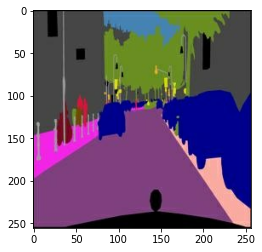

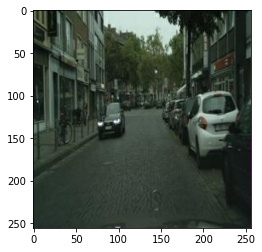

In [ ]:
inp, re = load(PATH+'train/100.jpg')
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp/255)
plt.figure()
plt.imshow(re/255)

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [ ]:
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

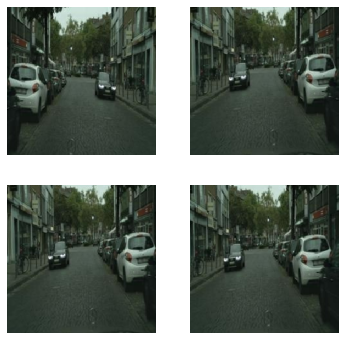

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_re/255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
from tensorflow.keras.layers import *
from numpy import power

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def Generator(filter, size):

  initializer = tf.random_normal_initializer(0., 0.02)

  input = tf.keras.layers.Input(shape=[256, 256, 3])
  inp = input
    
  down1 = Conv2D(filter, size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias=False)(inp)
  down1 = LeakyReLU(0.2)(down1)
  
  filter = filter*2  
  down2 = Conv2D(filter, size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias=False)(down1)
  down2 = LeakyReLU(0.2)(down2)

  filter = filter*2  
  down3 = Conv2D(filter, size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias=False)(down2)
  down3 = LeakyReLU(0.2)(down3)

  filter = filter*2  
  down4 = Conv2D(filter, size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias=False)(down3)
  down4 = LeakyReLU(0.2)(down4)
    
  down5 = Conv2D(filter, size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias=False)(down4)
  down5 = LeakyReLU(0.2)(down5)

  down6 = Conv2D(filter, size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias=False)(down5)
  down6 = LeakyReLU(0.2)(down6)

  down7 = Conv2D(filter, size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias=False)(down6)
  down7 = LeakyReLU(0.2)(down7)

  bottle = Conv2D(filter, size, strides=2, padding = 'same', kernel_initializer = initializer, use_bias=False)(down7)
  bottle = LeakyReLU(0.2)(bottle)
    
  up7 = Conv2DTranspose(filter, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(bottle)
  up7 = BatchNormalization()(up7)
  up7 = Dropout(0.5)(up7)
  up7 = ReLU()(up7)
  up7 = concatenate([up7,down7])
    
  up6 = Conv2DTranspose(filter, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(up7)
  up6 = BatchNormalization()(up6)
  up6 = Dropout(0.5)(up6)
  up6 = ReLU()(up6)
  up6 = concatenate([up6,down6])
  
  up5 = Conv2DTranspose(filter, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(up6)
  up5 = BatchNormalization()(up5)
  up5 = Dropout(0.5)(up5)
  up5 = ReLU()(up5)
  up5 = concatenate([up5,down5])
  
  up4 = Conv2DTranspose(filter, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(up5)
  up4 = BatchNormalization()(up4)
  up4 = ReLU()(up4)
  up4 = concatenate([up4,down4])
  
  filter = filter//2
  up3 = Conv2DTranspose(filter, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(up4)
  up3 = BatchNormalization()(up3)
  up3 = ReLU()(up3)
  up3 = concatenate([up3,down3])

  filter = filter//2
  up2 = Conv2DTranspose(filter, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(up3)
  up2 = BatchNormalization()(up2)
  up2 = ReLU()(up2)
  up2 = concatenate([up2,down2])

  filter = filter//2
  up1 = Conv2DTranspose(filter, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(up2)
  up1 = BatchNormalization()(up1)
  up1 = ReLU()(up1)
  up1 = concatenate([up1,down1])

  out = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')(up1)

  print(inp.shape)
  print(out.shape)
    
  model = tf.keras.Model(inputs=inp, outputs=out)
  return model

(None, 256, 256, 3)
(None, 256, 256, 3)


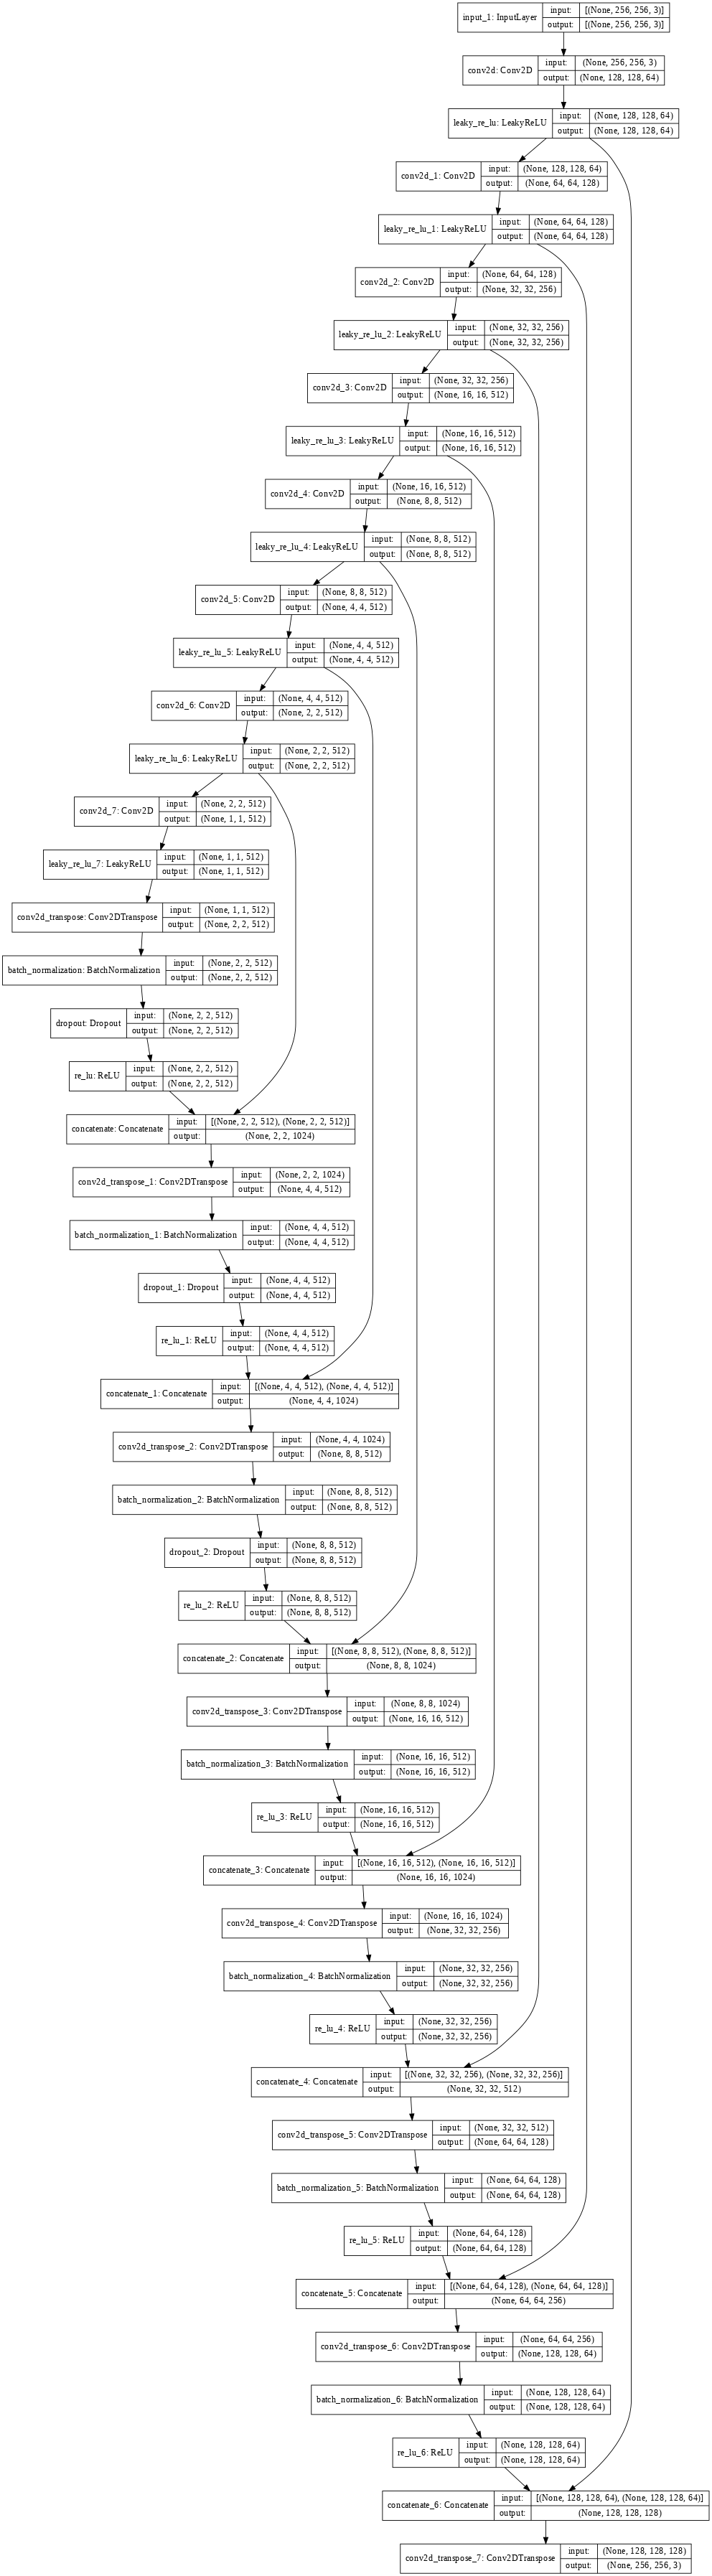

In [ ]:
generator = Generator(64, 4)
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


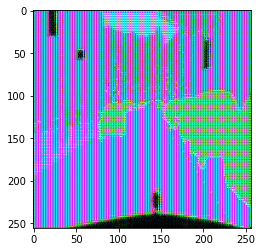

In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [ ]:
LAMBDA = 100

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [ ]:
def Discriminator():

  initializer = tf.random_normal_initializer(0., 0.02)

  input = tf.keras.layers.Input(shape=[256, 256, 3], name= 'Input Image')
  target = tf.keras.layers.Input(shape=[256, 256, 3], name= 'Output Image')

  x = concatenate([input, target])
  down1 = Conv2D(64, 4, strides=2, padding = 'same', kernel_initializer = initializer, activation= 'relu', use_bias=False)(x)
  down2 = Conv2D(128, 4, strides=2, padding = 'same', kernel_initializer = initializer, activation= 'relu', use_bias=False)(down1)
  down3 = Conv2D(256, 4, strides=2, padding = 'same', kernel_initializer = initializer, activation= 'relu', use_bias=False)(down2)

  pad1 = ZeroPadding2D()(down3)
  conv = Conv2D(512, 4, strides=1, kernel_initializer = initializer, use_bias=False)(pad1)
  batchnorm1 = BatchNormalization()(conv)
  lrelu = LeakyReLU()(batchnorm1)

  pad2 = ZeroPadding2D()(lrelu)
  out = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(pad2)

  return tf.keras.Model(inputs=[input, target], outputs= out)

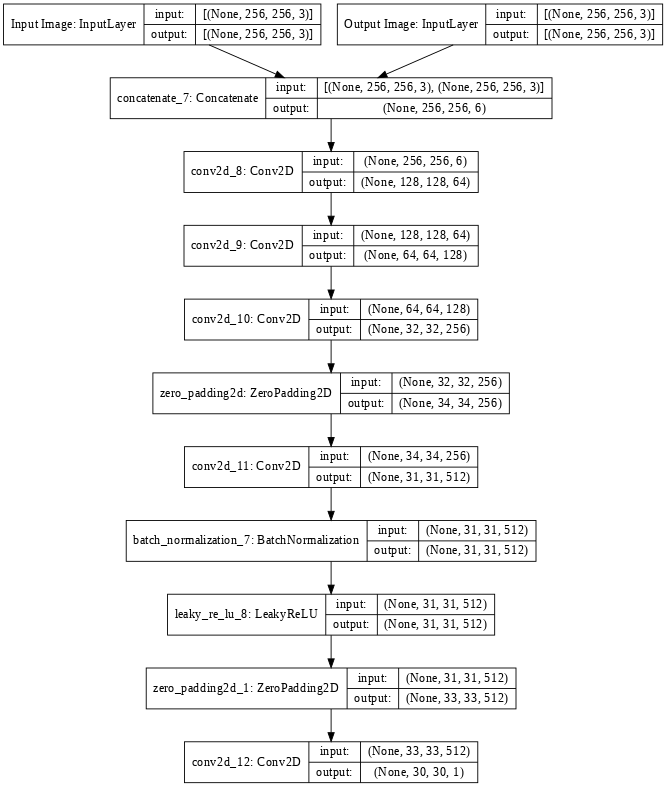

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

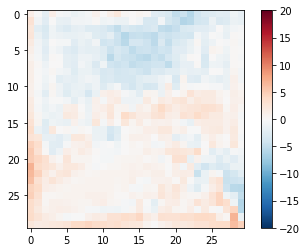

In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/ComputerVision/pix2pix_GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

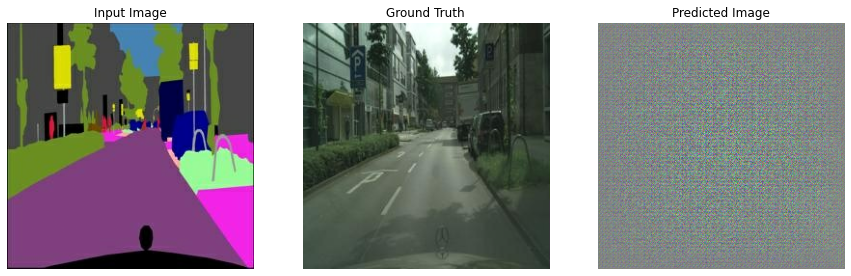

In [ ]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [ ]:
import datetime
log_dir="/content/drive/MyDrive/ComputerVision/pix2pix_GAN/logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)

  return disc_loss, gen_total_loss

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    
    f = open('/content/drive/MyDrive/ComputerVision/pix2pix_GAN/loss.txt', 'a')
    dloss = 0
    gloss = 0
    
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      d,g = train_step(input_image, target, epoch)
      dloss = dloss+d.numpy()
      gloss = gloss+ g.numpy()
    print()

    f.write(str(epoch)+','+str(dloss/len(train_ds))+','+str(gloss/len(train_ds))+'\n')  
    f.close()
    
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

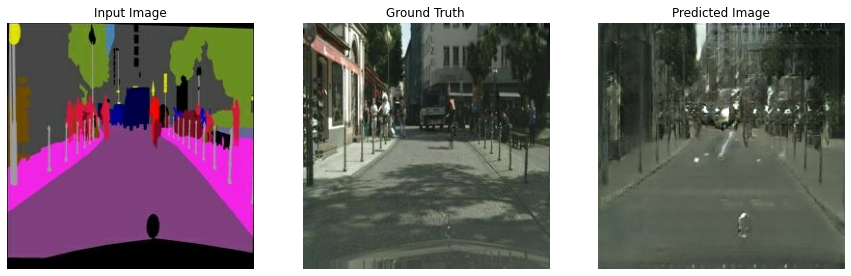

Epoch:  199
....................................................................................................
......................................................................................
Time taken for epoch 200 is 64.36053419113159 sec



In [ ]:
EPOCHS = 200
fit(train_dataset, EPOCHS, test_dataset)

In [ ]:
import matplotlib.pyplot as plt

def plot_loss():

  dloss = []
  gloss = []
  epoch = []

  with open('/content/drive/MyDrive/ComputerVision/pix2pix_GAN/loss.txt', 'r') as f:
    for i in f.readlines():
      e, d, g = i.split(',')  
      epoch.append(int(e))
      dloss.append(round(float(d),2))
      gloss.append(round(float(g),2))

  plt.title('discriminator loss')
  plt.plot(epoch, dloss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()
  
  plt.title('generator loss')
  plt.plot(epoch, gloss)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.show()

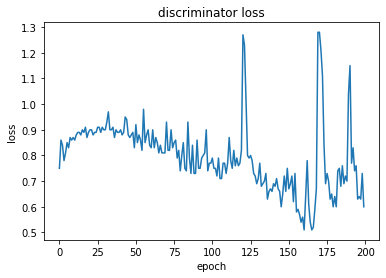

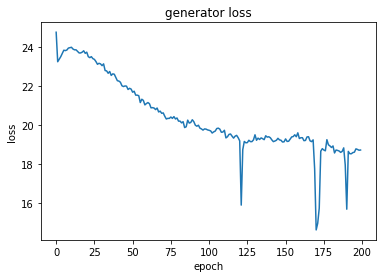

In [ ]:
plot_loss()

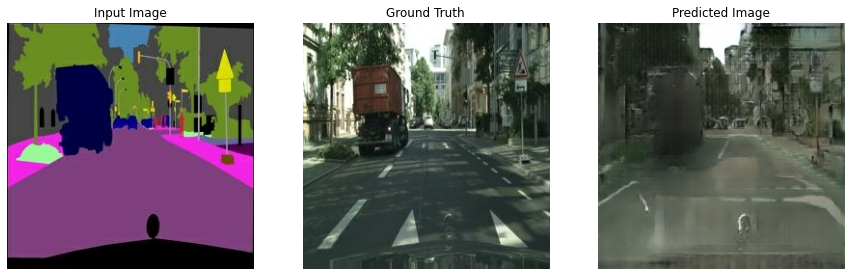

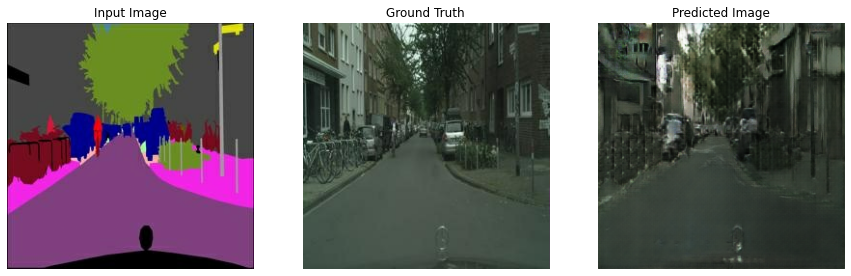

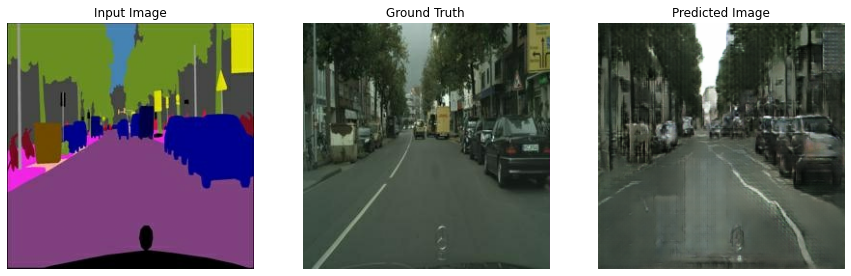

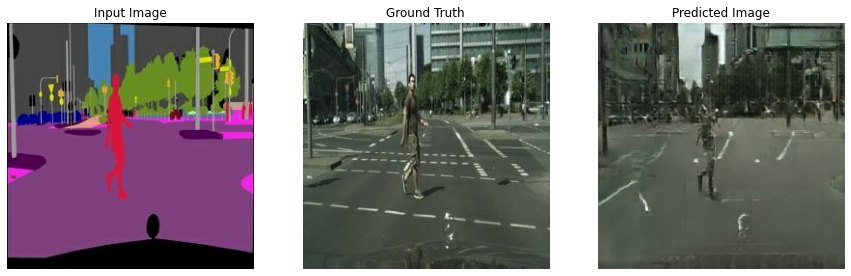

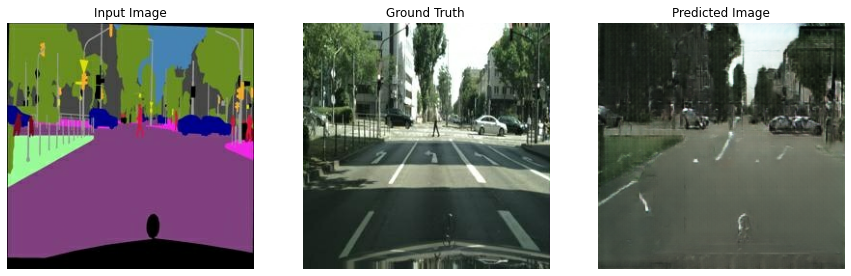

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
tf.train.latest_checkpoint('/content/drive/MyDrive/ComputerVision/pix2pix_GAN/training_checkpoints')

'/content/drive/MyDrive/ComputerVision/pix2pix_GAN/training_checkpoints/ckpt-42'

In [ ]:
checkpoint.restore('/content/drive/MyDrive/ComputerVision/pix2pix_GAN/training_checkpoints/ckpt-42')

In [ ]:
def fit_model(train_ds, start_epoch, epochs, test_ds):
  for epoch in range(start_epoch,epochs):
    
    f = open('/content/drive/MyDrive/ComputerVision/pix2pix_GAN/loss.txt', 'a')
    dloss = 0
    gloss = 0
    
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      d,g = train_step(input_image, target, epoch)
      dloss = dloss+d.numpy()
      gloss = gloss+ g.numpy()
    print()

    f.write(str(epoch)+','+str(dloss/len(train_ds))+','+str(gloss/len(train_ds))+'\n')  
    f.close()
    # saving (checkpoint) the model every 20 epochs
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)

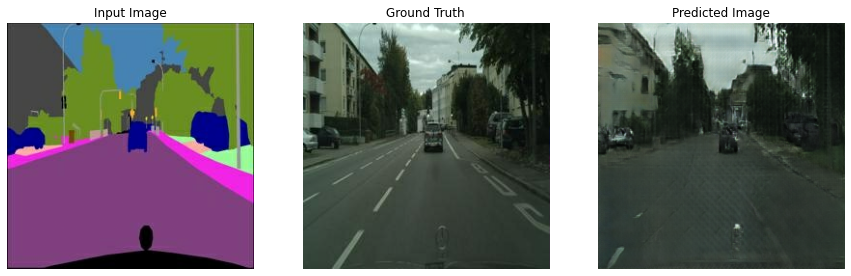

Epoch:  499
....................................................................................................
......................................................................................
Time taken for epoch 500 is 66.00918245315552 sec



In [ ]:
EPOCHS = 500
START_EPOCH = 200
fit_model(train_dataset, START_EPOCH, EPOCHS, test_dataset)

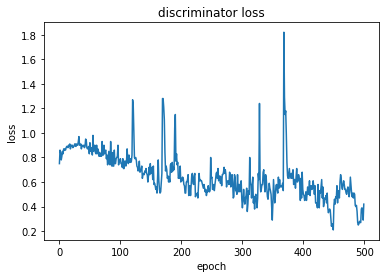

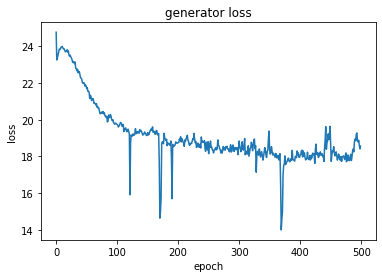

In [ ]:
plot_loss()

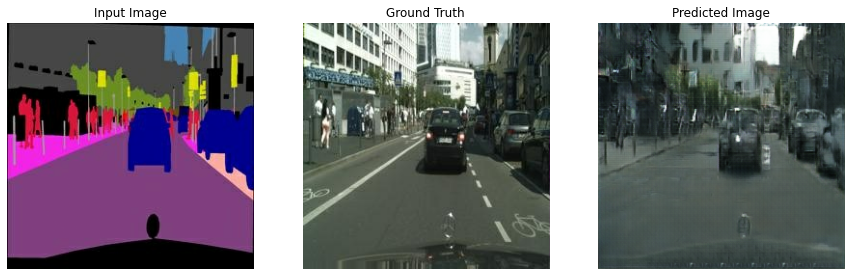

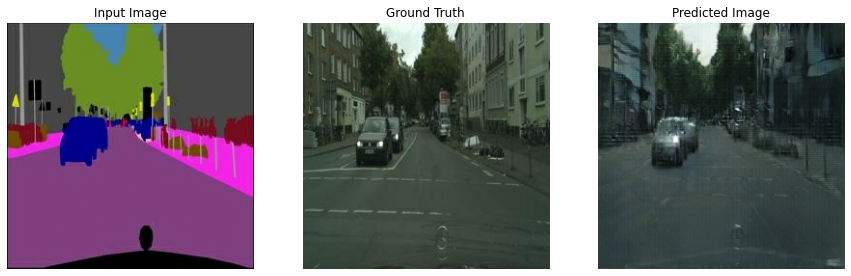

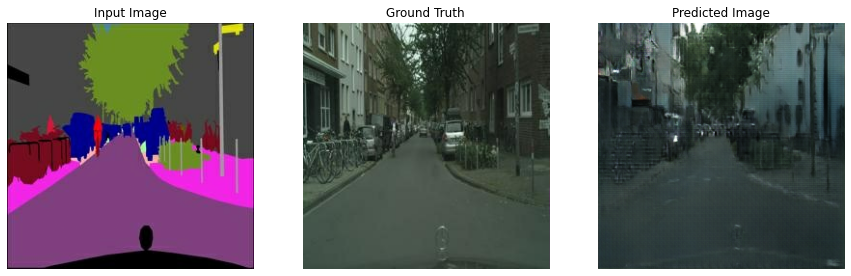

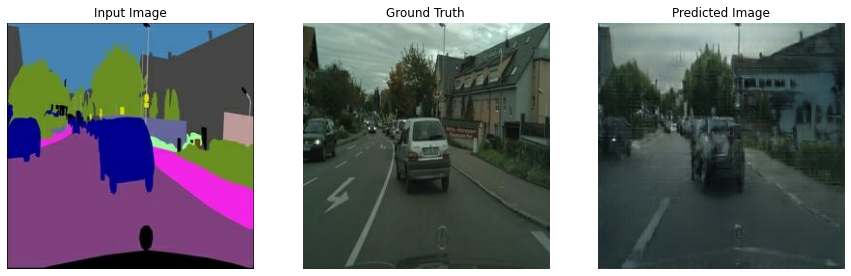

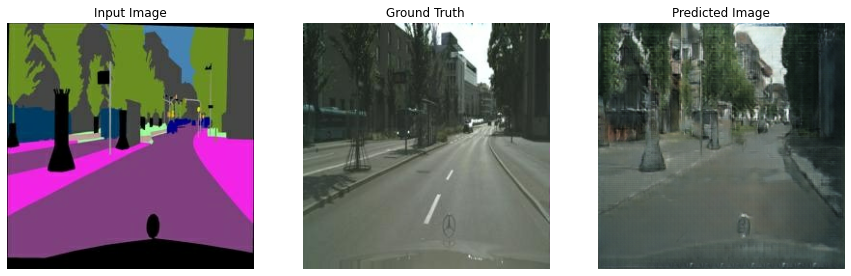

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

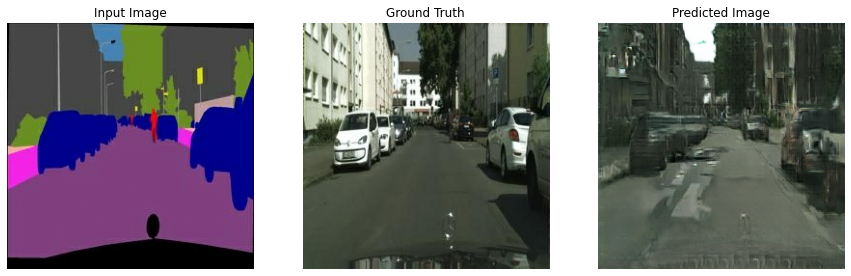

Epoch:  699
....................................................................................................
......................................................................................
Time taken for epoch 700 is 62.730650186538696 sec



In [ ]:
EPOCHS = 700
START_EPOCH = 500
fit_model(train_dataset, START_EPOCH, EPOCHS, test_dataset)

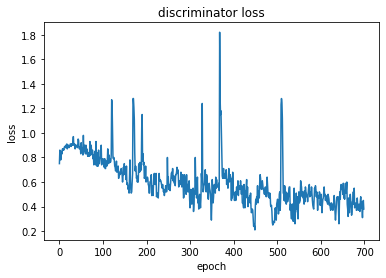

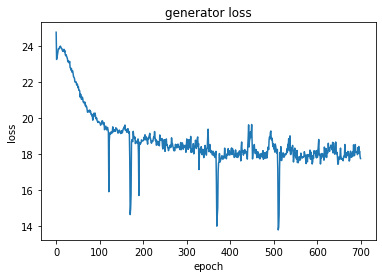

In [ ]:
plot_loss()

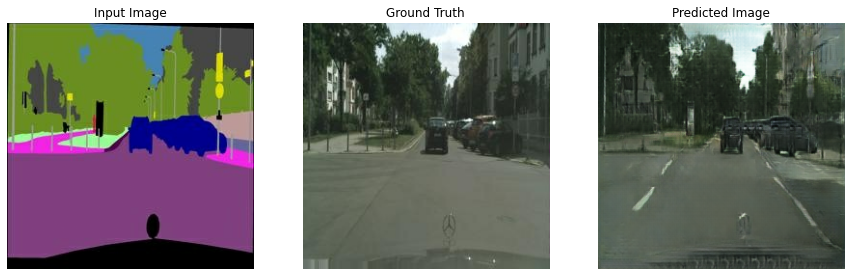

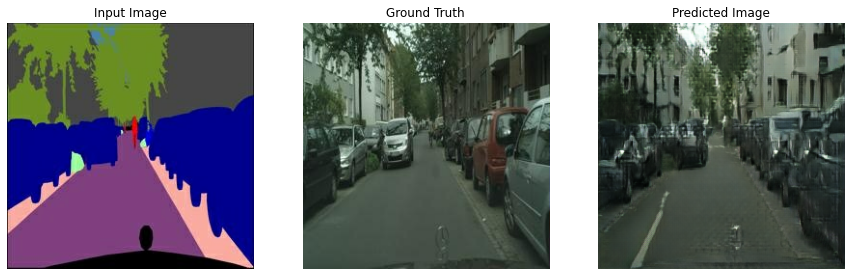

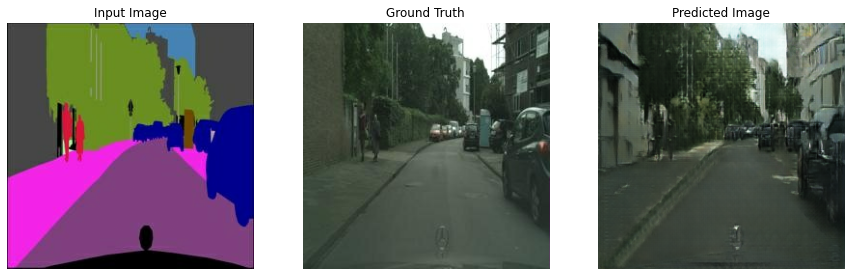

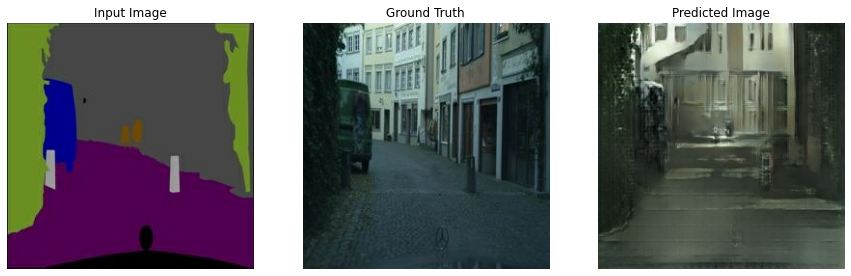

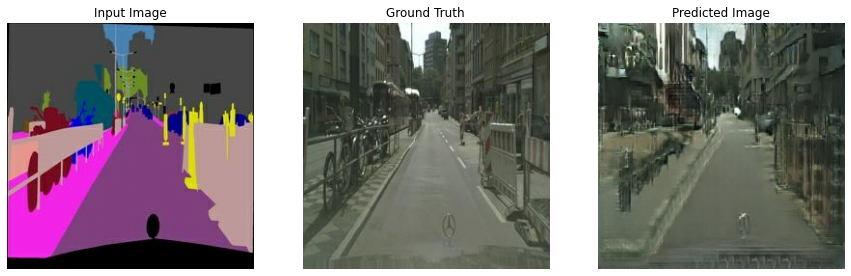

In [ ]:
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [ ]:
tf.train.latest_checkpoint('/content/drive/MyDrive/ComputerVision/pix2pix_GAN/training_checkpoints')

'/content/drive/MyDrive/ComputerVision/pix2pix_GAN/training_checkpoints/ckpt-63'

In [ ]:
checkpoint.restore('/content/drive/MyDrive/ComputerVision/pix2pix_GAN/training_checkpoints/ckpt-63')